In [1]:
!pwd
!pip install -r ./requirements.txt

/work/08823/msrodlab/maverick2/font-diffusion
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


# Dataset creation. Run during first time setup

In [6]:
import os
import string
import csv
from fontpreview import FontPreview
import pandas as pd
import requests
import io
from zipfile import ZipFile
import json
import shutil
import uuid
from tqdm.notebook import tqdm
from datasets import load_dataset, Image
from fontTools.ttLib import TTFont
from fontTools.unicode import Unicode


def has_glyph(font, glyph):
    for table in font['cmap'].tables:
        if ord(glyph) in table.cmap.keys():
            return True
    return False

#For a given font file, create the alphabet and the numbers 0-9
def create_alphabet(font_file, image_folder):
    font = FontPreview(font_file)
    ttf_font = TTFont(font_file)
    font_name = font.font.getname()[0]
    included_chars = []
    for char in string.ascii_letters:
        if has_glyph(ttf_font, char):
            included_chars.append(char)
    for char in string.digits:
        if has_glyph(ttf_font, char):
            included_chars.append(char)
    split_folder = 'train'
    if len(included_chars) != 62:
        split_folder = 'test'
        
        
    save_path = os.path.join(image_folder, split_folder, font_name)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for char in included_chars:
        font.font_text = char
        font.bg_color = (0, 0, 0)  # white BG
        font.dimension = (512, 512)  # Dimension consistent with the default resolution for diffusion models
        font.fg_color = (255, 255, 255)  # Letter color
        font.set_font_size(300)  # font size ~ 300 pixels
        font.set_text_position('center')  # center placement

        if char in string.ascii_lowercase:
            image_file_name = 'lower_' + char + '.jpg'
        elif char in string.ascii_uppercase:
            image_file_name = 'upper_' + char + '.jpg'
        else:
            image_file_name = char + '.jpg'
        font.save(os.path.join(save_path, image_file_name))

def create_alphabet_for_each_ttf():
    TTF_DIR = os.path.join(os.path.abspath(os.getcwd()), 'ttf-files')
    IMG_DIR = os.path.join(os.path.abspath(os.getcwd()), 'font-images')
    if not os.path.exists(IMG_DIR):
        os.mkdir(IMG_DIR)
    fnames = os.listdir(TTF_DIR)

    for fname in tqdm(fnames):
        TTF_PATH = os.path.join(TTF_DIR, fname)
        create_alphabet(TTF_PATH, IMG_DIR)

    

#Uses pandas to read through the CSV from sheets without the need of constantly redownloading
def get_font_ttfs():
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv('font_dataset.csv')
    # Create data folder if it does not exist
    if not os.path.exists('ttf-files'):
        os.makedirs('ttf-files')
    # Loop through each row of the DataFrame
    for index, row in tqdm(df.iterrows()):
        # Get the link and filename for the current row
        link = row['Link']
        filename = row['Filename']
        if os.path.exists(os.path.join('ttf-files', filename)):
            continue
            
        
        # Download the zip file from the link
        response = requests.get(link, stream=True)
        with open('temp.zip', 'wb') as temp_file:
            shutil.copyfileobj(response.raw, temp_file)
        del response
        
        # Unzip the downloaded file
        with ZipFile('temp.zip', 'r') as zip_file:
            zip_file.extract(filename)
            
        # Move the file to the data folder
        source_path = os.path.join(os.getcwd(), filename)
        dest_path = os.path.join(os.getcwd(), 'ttf-files', filename)
        shutil.move(source_path, dest_path)
        
        # Remove the temporary zip file
        os.remove('temp.zip')


#Create the jsonl file and training folder for the images
def create_dataset():
    FONT_IMAGE_PATH = os.path.join(os.getcwd(), 'font-images')
    assert os.path.exists(FONT_IMAGE_PATH)
    TTF_PATH = os.path.join(os.getcwd(), 'ttf-files')
    assert os.path.exists(TTF_PATH)
    CSV_PATH = os.path.join(os.getcwd(), 'font_dataset.csv')

    
    # Step 1: Initialize the json file
    # Step 2: Loop through the Dataframe, for each row the Filename column corresponds to the actual
    #         folder name in 'font_images'.
    # Step 3: For each image in the respective folder, copy it over to the training folder (renaming it) and add its entry
    #         to the jsonl file

    #Step 1
    json_metadata = []
    # if not os.path.exists(training_data_path):
    #     os.makedirs(training_data_path)


    #Step 2
    df = pd.read_csv(CSV_PATH)
    dataset = {'test':[], 'train': []}
    head = df.head()
    for idx, row_data in df.iterrows():
        ttf_path = os.path.join(TTF_PATH, row_data['Filename'])
        font_img_dir = FontPreview(ttf_path).font.getname()[0]
        split_folder = 'train'
        font_img_dir_path = os.path.join(FONT_IMAGE_PATH, split_folder, font_img_dir)
        if not os.path.exists(font_img_dir_path):
            split_folder = 'test'
            font_img_dir_path = os.path.join(FONT_IMAGE_PATH, split_folder, font_img_dir)
        font_img_paths = [os.path.join(font_img_dir_path, fname) for fname in os.listdir(font_img_dir_path)]
        included_chars = [cur_img_path.split('/')[-1].split('.')[0] for cur_img_path in font_img_paths]
        json_data_row = {
            'uniqueId': str(uuid.uuid4()),
            'font_img_paths': font_img_paths,
            'ttf_path': ttf_path,
            'font_characteristics': row_data['Descriptors'], 
            'chars': included_chars,
            'font_properties': {
                'font_weight': row_data['Weight'], 
                'rounding': row_data['Courner Rounding'], 
                'font_serifs': row_data['Serif'],
                'width': row_data['Width'],
                'capitals': row_data['Capitals'],
                'dynamics': row_data['Dynamics'] 
            }
        }
        dataset[split_folder].append(json_data_row)
    #Create the jsonl file
    with open('metadata.jsonl', 'w') as f:
        json.dump(dataset, f)




# if __name__ == '__main__':
    #get_fonts('font_files', 'font_images')
    #create_dataset('font_images', 'font_files', 'train')


In [7]:
create_dataset()

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /home1/08823/msrodlab/.cache/huggingface/datasets/json/default-10ea592188ad1416/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/12728 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /home1/08823/msrodlab/.cache/huggingface/datasets/imagefolder/default-62dfb38bc3bc9dfe/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

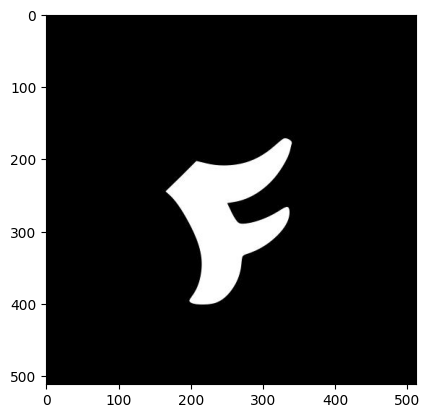

In [15]:
import matplotlib.pyplot as plt
path='/work/08823/msrodlab/maverick2/font-diffusion/font-images/Rayman 2/lower_f.jpg'
pil_im = Image.open(path, 'r')
plt.imshow(pil_im)

In [3]:
get_font_ttfs()

0it [00:00, ?it/s]

In [64]:
!rm -rf font-images

In [10]:
# shouldnt run this on TACC, best to scp the files from your own computer
# scp localhost/font-diffusion/font-images.tar <your_user>@maverick2.tacc.utexas.edu:\$WORK/font-diffusion
create_alphabet_for_each_ttf()

  0%|          | 0/208 [00:00<?, ?it/s]

NameError: name 'dataset' is not defined

In [1]:
!pip install datasets[vision]

In [1]:
dataset = load_dataset("imagefolder", data_dir="font-images")

NameError: name 'load_dataset' is not defined